In [1]:
benchmark = '^GSPC' #(s&p 500) or '^DJI' #(Dow Jones) or '000300.SS' #CSI 300
stock = 'AAPL'
fees = 0

In [2]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
benchmark_df = yfinance.download(benchmark, period='8y')

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
STD: 0.017868807194788394
average return: 0.001201238001164288
average return after a positive return: 0.0010608241051786806


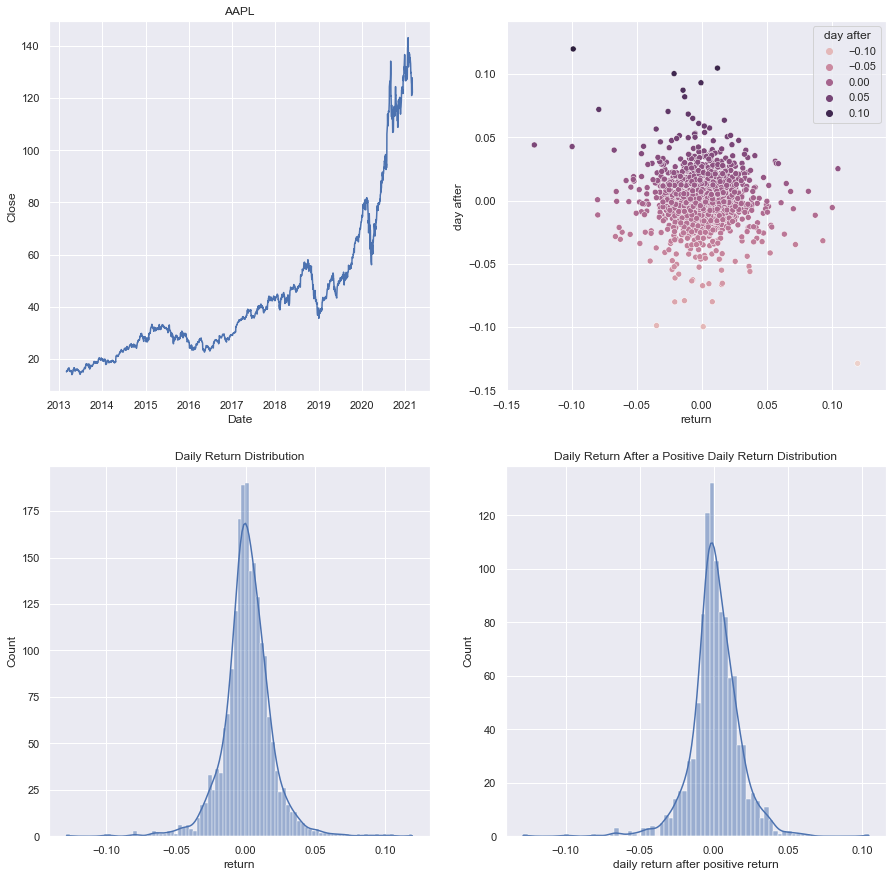

In [4]:
df = yfinance.download(stock, period='8y')
df['return'] = df['Close'].iloc[1:]/df['Close'].iloc[0:len(df)-1].values - 1
df['day after'] = [np.nan] + df['return'].iloc[2:].tolist() + [np.nan]
df['daily return after positive return'] = df['day after'][df['return'].values > 0]
df['SMA5'] = df['Close'].iloc[:].rolling(5).mean()
print(f"STD: {np.std(df['return'])}")
print(f'average return: {np.mean(df["return"])}\naverage return after a positive return: {np.mean(df["daily return after positive return"])}')

f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.lineplot(data=df, x="Date", y="Close", ax=axes[0,0])
axes[0,0].set_title(stock)
sns.scatterplot(data=df, x="return", y="day after", hue="day after", ax=axes[0,1])
sns.histplot(data=df, x="return", kde=True, ax=axes[1,0])
axes[1,0].set_title('Daily Return Distribution')
sns.histplot(data=df, x="daily return after positive return", kde=True, ax=axes[1,1])
axes[1,1].set_title('Daily Return After a Positive Daily Return Distribution')
f.savefig(f'./images/{stock}-analysis.png')
plt.show()

In [5]:
hold_list_cls2cls = [] # opens a position when daily return is positive "market on close" order type
hold_list_opn2opn = [] # opens a position when daily return is positive "market on open"
hold_list_cls2cls2 = [] # opens a position when open is positive "market on close" order type
hold_list_ma5vprc = [] # opens a position when daily return is higher than SMA5 "market on close" 
hold_list_highnlow = [] # opens a position when price rose 2% or closes when price fell 2%, "market on close"
hold_list_highnlow2 = [] # opens a position when price rose 2% or closes when price fell 2%, "market if touched"
hold_list = [hold_list_cls2cls, hold_list_opn2opn, hold_list_cls2cls2, 
             hold_list_ma5vprc, hold_list_highnlow, hold_list_highnlow2]
positionclosed = [True for _ in hold_list]
for i in range(4, len(df)-1):
    if df['Close'].iloc[i] > df['Close'].iloc[i-1]: #Close Price(Day[i]) > Close Price(Day[i-1])
        hold_list[0].append(df['Close'].iloc[i])
        hold_list[1].append(df['Open'].iloc[i+1])
        positionclosed[0] = False
        positionclosed[1] = False
    else:
        if not positionclosed[0]:
            hold_list[0].append(df['Close'].iloc[i])
            positionclosed[0] = True
        else:
            hold_list[0].append(np.nan)
            
        if not positionclosed[1]:
            hold_list[1].append(df['Open'].iloc[i+1])
            positionclosed[1] = True
        else:
            hold_list[1].append(np.nan)
            
    
    if df['Open'].iloc[i] > df['Close'].iloc[i-1]:
        hold_list[2].append(df['Close'].iloc[i])
        positionclosed[2] = False
    else:
        if not positionclosed[2]:
            hold_list[2].append(df['Close'].iloc[i])
            positionclosed[2] = True
        else:
            hold_list[2].append(np.nan)
    
    if df['Close'].iloc[i] > df['SMA5'].iloc[i]:
        hold_list[3].append(df['Close'].iloc[i])
        positionclosed[3] = False
    else:
        if not positionclosed[3]:
            hold_list[3].append(df['Close'].iloc[i])
            positionclosed[3] = True
        else:
            hold_list[3].append(np.nan)
            
    if df['High'].iloc[i] > df['Close'].iloc[i-1] * 1.02:
        hold_list[4].append(df['Close'].iloc[i])
        hold_list[5].append(max(df['Open'].iloc[i], df['Close'].iloc[i-1] * 1.02))
        positionclosed[4] = False
        positionclosed[5] = False
    elif (not positionclosed[4]) and (df['Low'].iloc[i] < df['Close'].iloc[i-1] * 0.98):
        hold_list[4].append(df['Close'].iloc[i])
        hold_list[5].append(min(df['Open'].iloc[i], df['Close'].iloc[i-1] * 0.98))
        positionclosed[4] = True
        positionclosed[5] = True
    else:
        if not positionclosed[4]:
            hold_list[4].append(df['Close'].iloc[i])
        else:
            hold_list[4].append(np.nan)
            
        if not positionclosed[5]:
            hold_list[5].append(df['Close'].iloc[i])
        else:
            hold_list[5].append(np.nan)

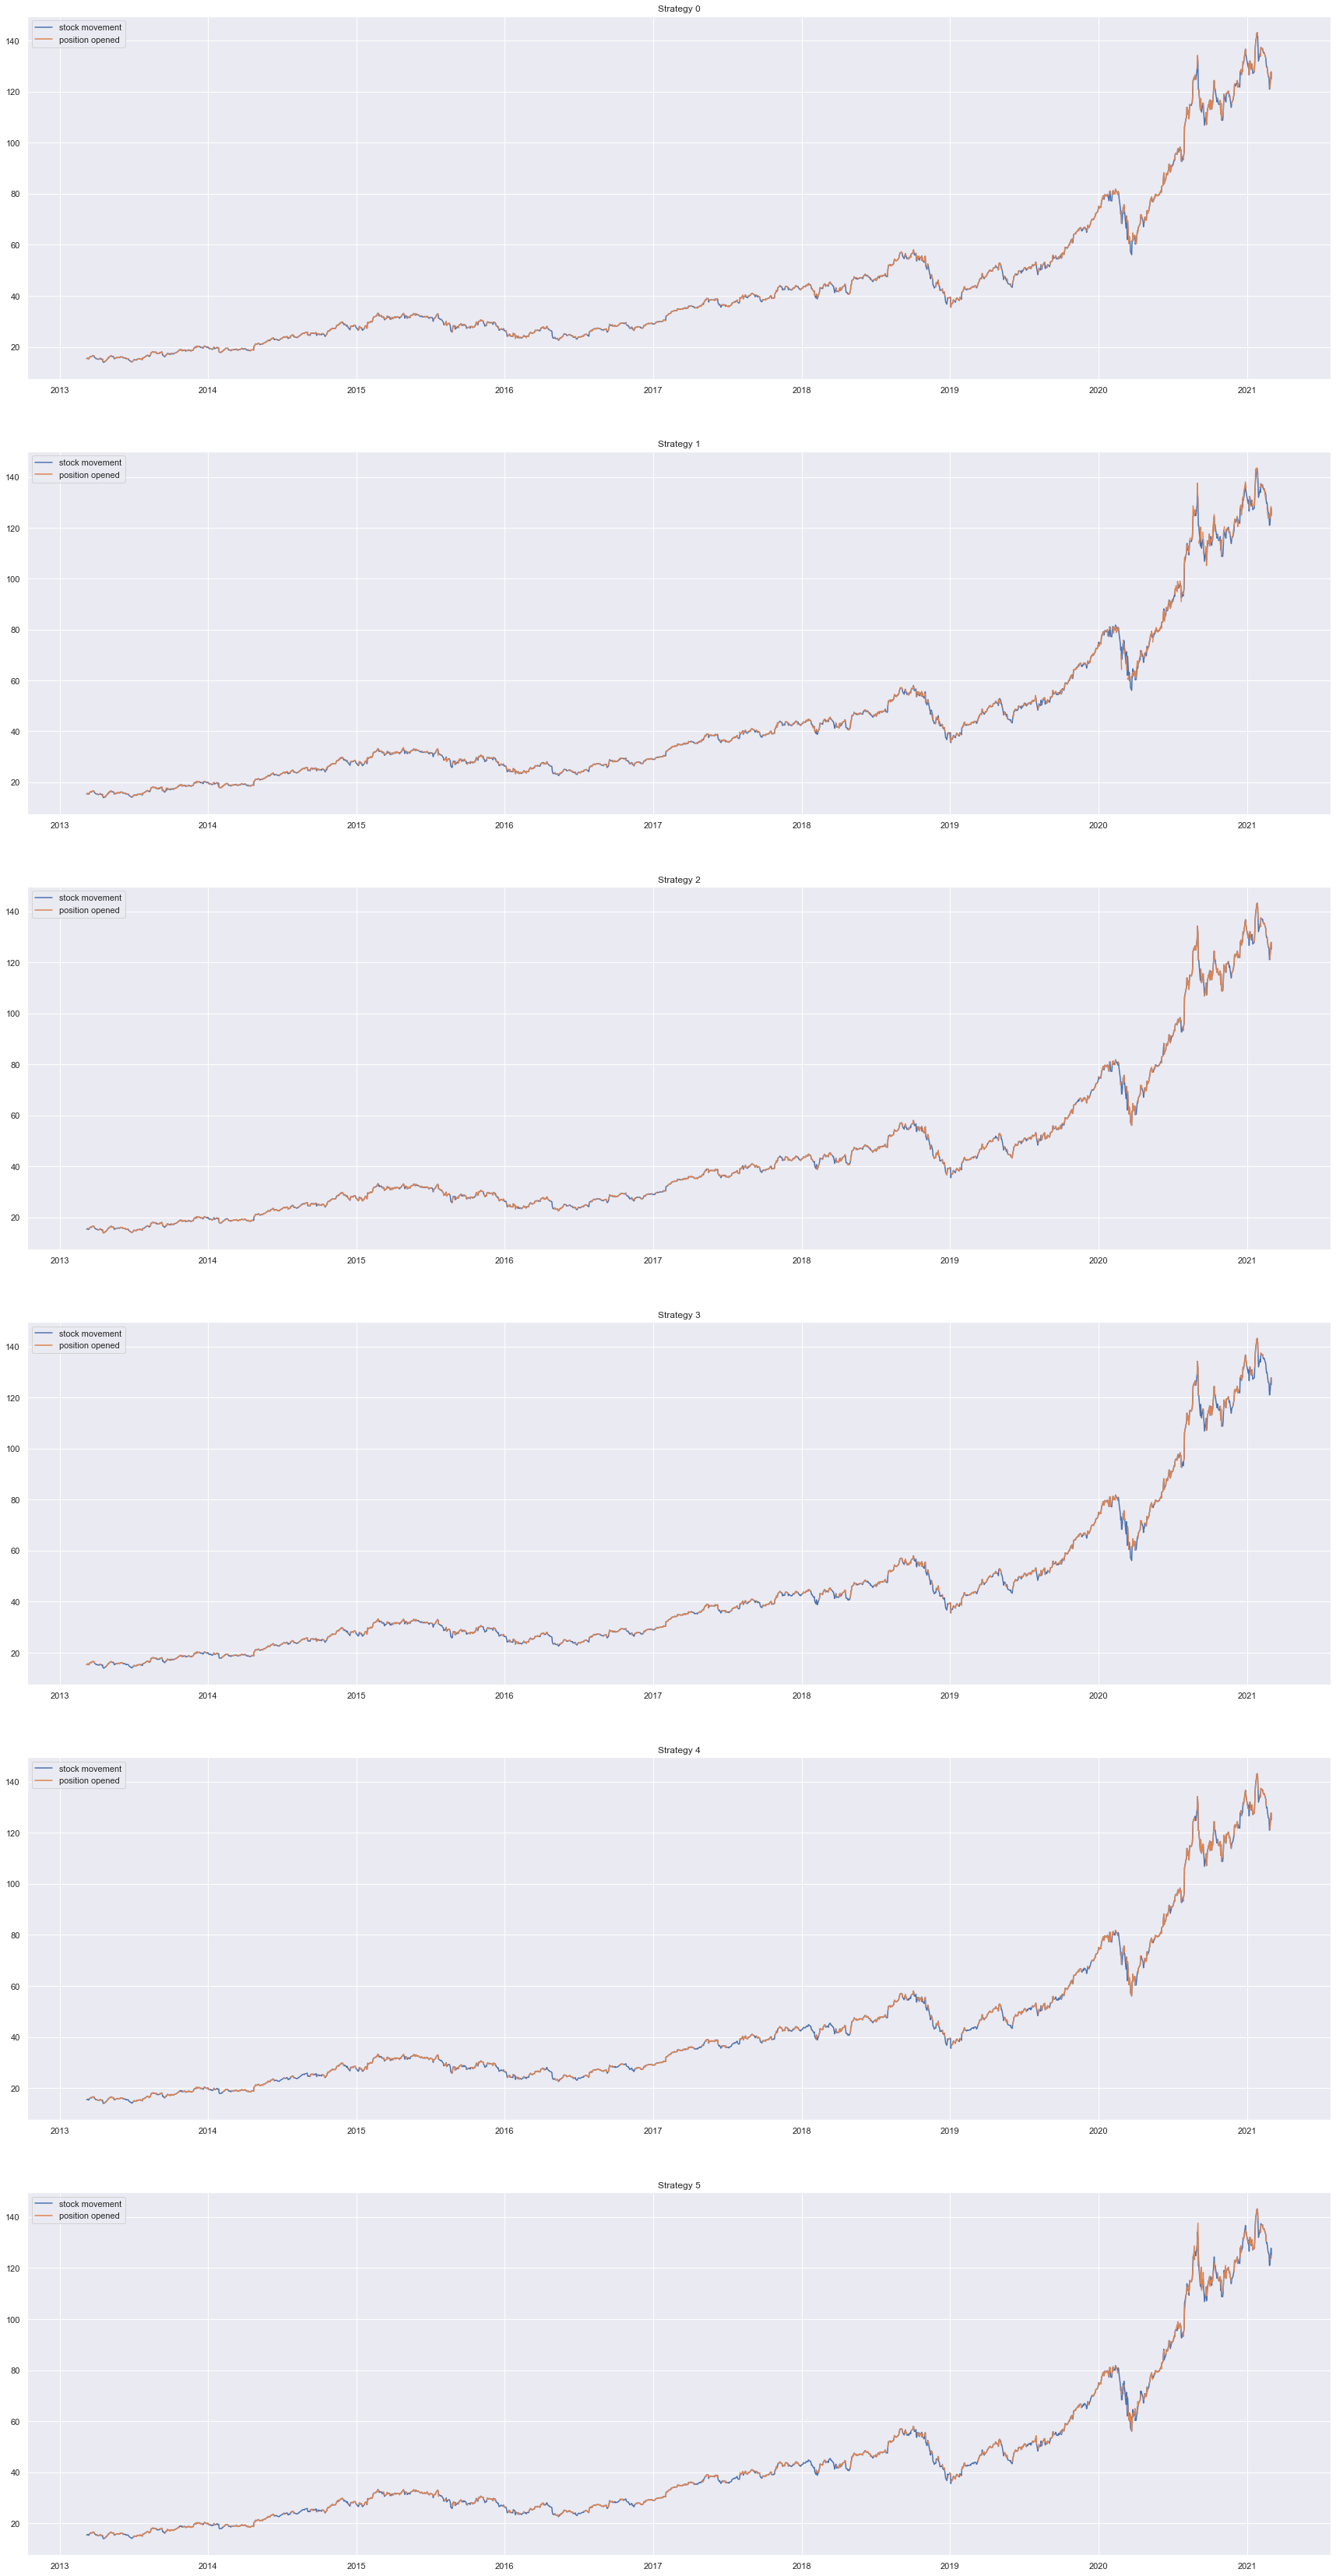

In [6]:
f, axes = plt.subplots(6, 1, figsize=(30, 60))
for i, hlist in enumerate(hold_list):
    axes[i].plot(df.index.values[4:len(df)-1], df['Close'].values[4:len(df)-1])
    axes[i].plot(df.index.values[4:len(df)-1], hlist)
    axes[i].legend(['stock movement', 'position opened'])
    axes[i].set_title(f'Strategy {i}')
    
f.savefig(f'./images/{stock}-position-opened-8y.png')

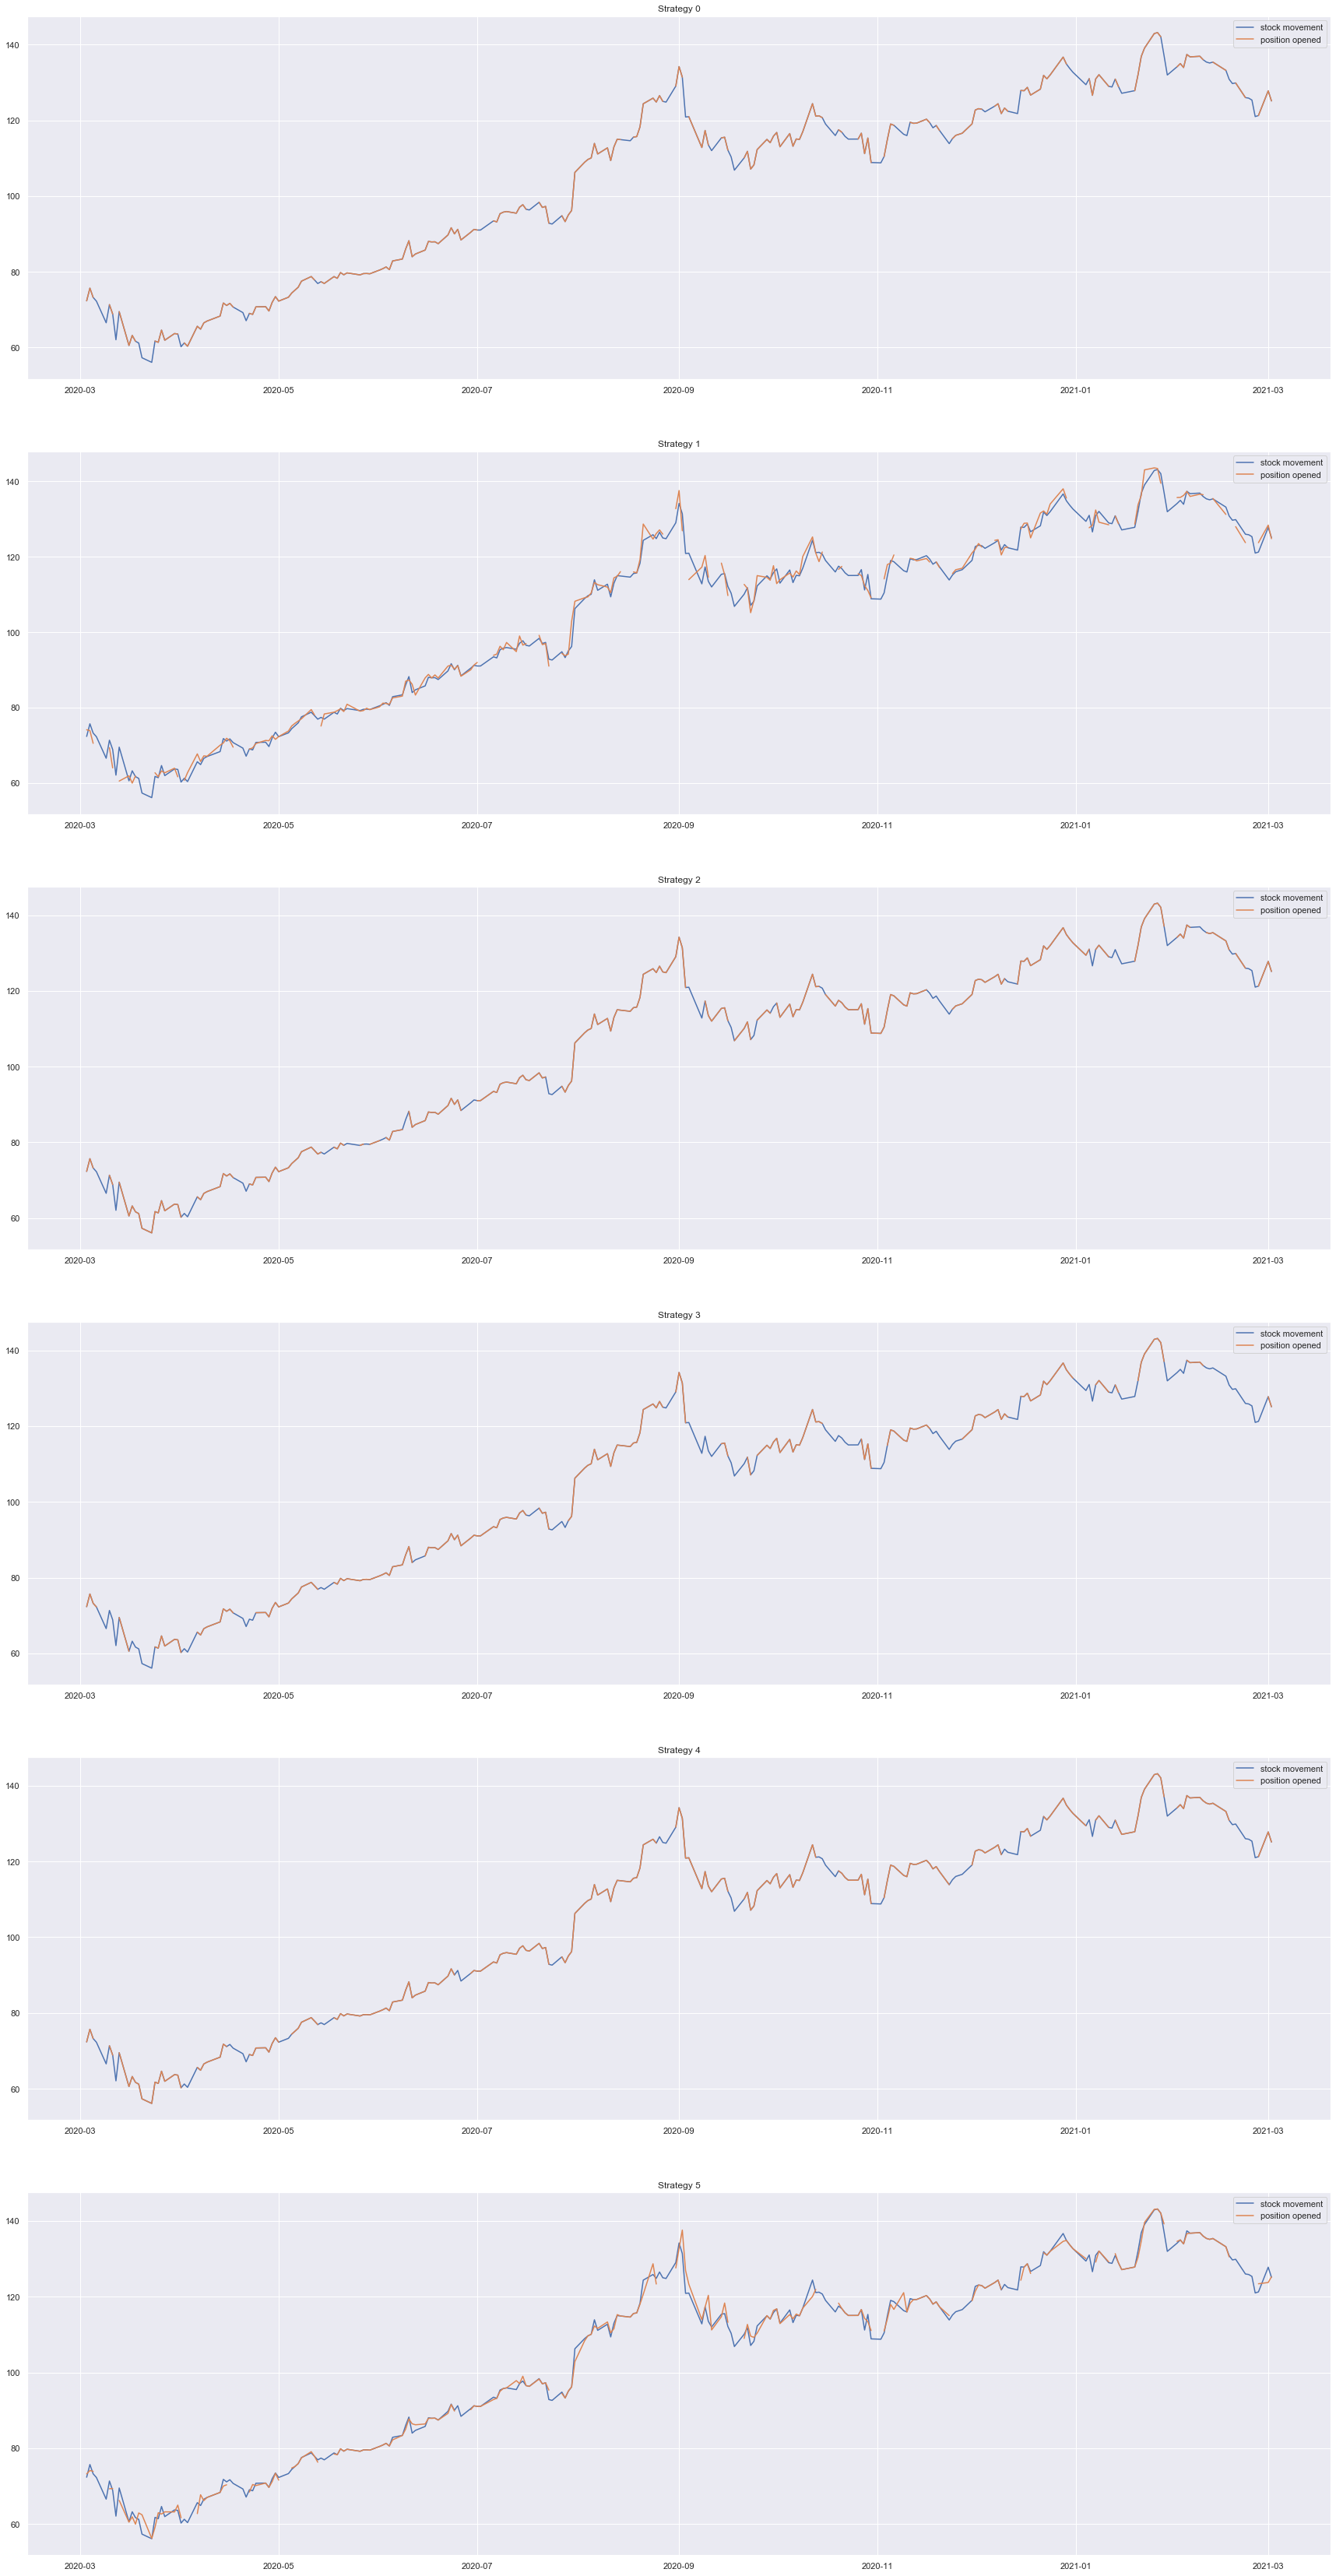

In [7]:
f, axes = plt.subplots(6, 1, figsize=(30, 60))
for i, hlist in enumerate(hold_list):
    axes[i].plot(df.index.values[-253:-1], df['Close'].values[-253:-1])
    axes[i].plot(df.index.values[-253:-1], hlist[-252:])
    axes[i].legend(['stock movement', 'position opened'])
    axes[i].set_title(f'Strategy {i}')
    
f.savefig(f'./images/{stock}-position-opened-1y.png')

In [8]:
def calculate_return(hlist, fees=0):
    return_list = np.ones((len(hlist)), dtype='float32')
    
    for i in range(1, len(hlist)):
        if np.isnan(hlist[i]) | np.isnan(hlist[i-1]):
            return_list[i] = return_list[i-1]
            
        else:
            if (i < 2) | np.isnan(hlist[i-2]):
                return_list[i] = return_list[i-1] * (hlist[i]/(hlist[i-1]*(1+fees)))
            elif (i + 1 > len(hlist) - 1) or np.isnan(hlist[i+1]):
                return_list[i] = return_list[i-1] * ((hlist[i]*(1-fees))/hlist[i-1])
            else:
                return_list[i] = return_list[i-1] * (hlist[i]/hlist[i-1])
    return return_list

def sharp_ratio(vlist, num_yrs=8, Rf=0.035):
    apr = vlist[-1] ** (1/8) - 1
    returns = []
    workdays = len(vlist)//num_yrs
    for i in range(num_yrs):
        returns.append(vlist[workdays*(i+1)]/vlist[workdays*i])
        
    std = np.std(returns)
    
    return (apr - Rf)/std

In [9]:
value_list = [calculate_return(i, fees=fees) for i in hold_list]

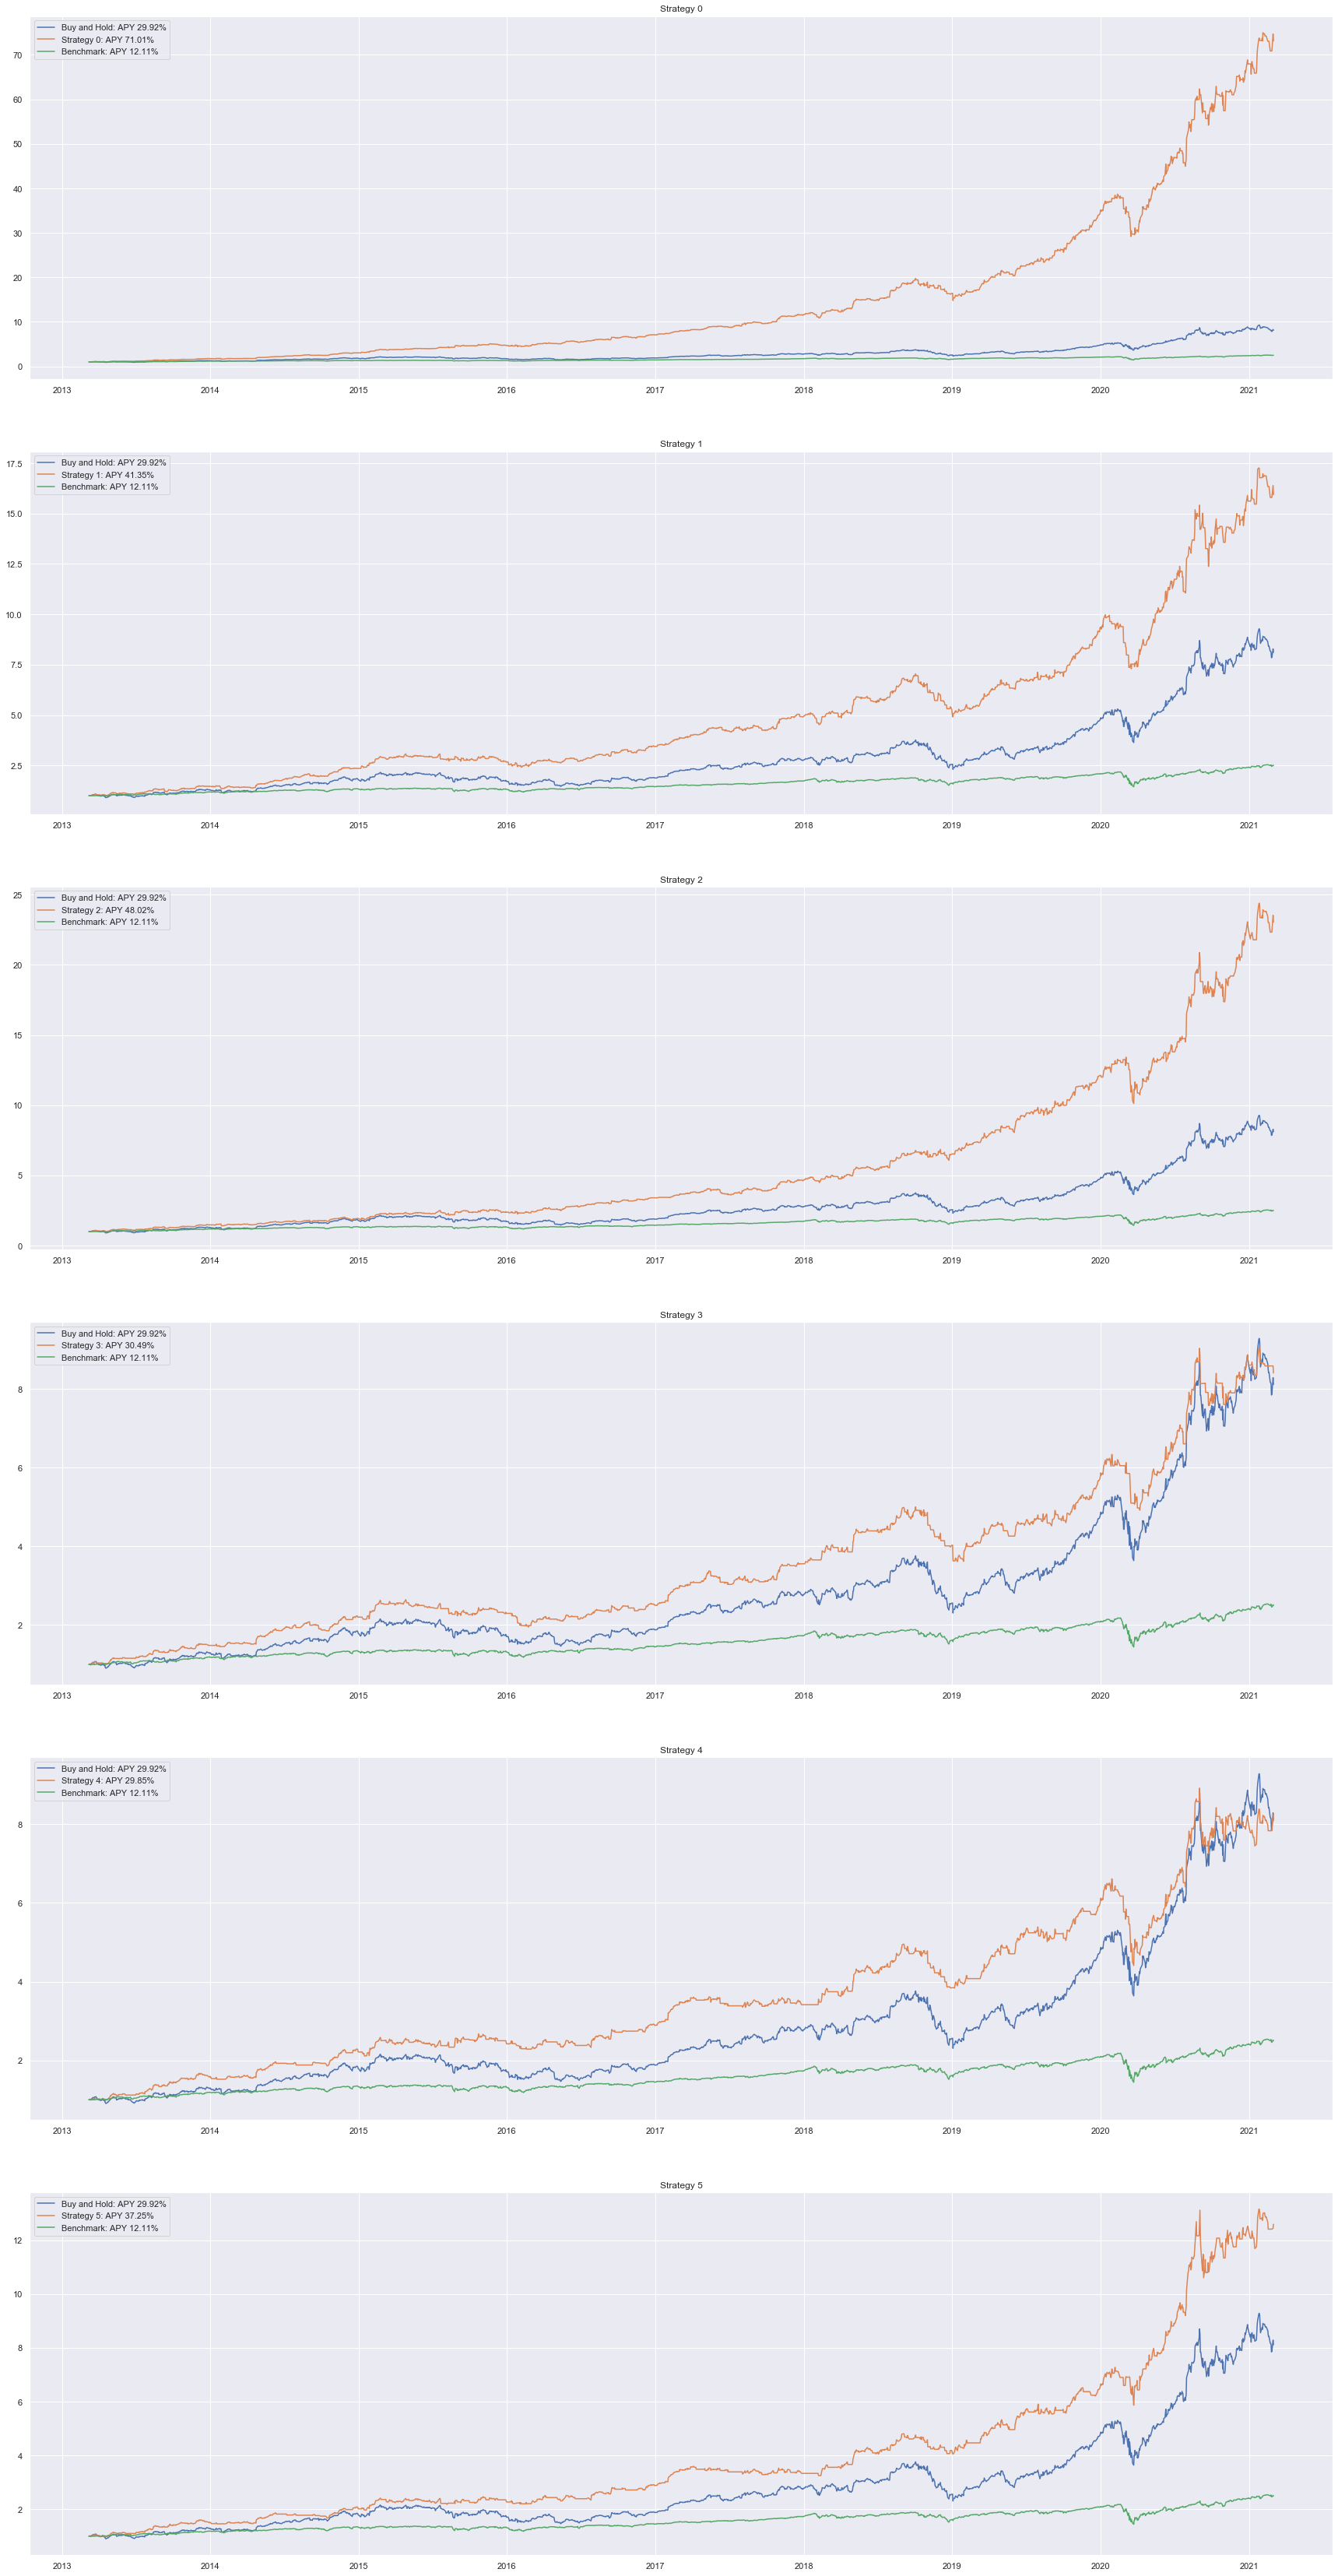

In [10]:
f, axes = plt.subplots(6, 1, figsize=(30, 60))
for i, vlist in enumerate(value_list):
    axes[i].plot(df.index.values[4:len(df)-1], df['Close'].values[4:len(df)-1]/df['Close'].values[4])
    axes[i].plot(df.index.values[4:len(df)-1], vlist)
    axes[i].plot(df.index.values[4:len(df)-1], 
                 benchmark_df['Close'].values[4:len(df)-1]/benchmark_df['Close'].values[4])
    axes[i].legend([f"Buy and Hold: APY {round(((df['Close'].values[-2]/df['Close'].values[4])**(1/8)-1)*100, 2)}%",
                    f'Strategy {i}: APY {round((vlist[-1]**(1/8)-1)*100, 2)}%', 
                    f"Benchmark: APY {round(((benchmark_df['Close'].values[-2]/benchmark_df['Close'].values[4])**(1/8)-1)*100, 2)}%"
                   ])
    axes[i].set_title(f'Strategy {i}')
    
f.savefig(f'./images/{stock}-return-8y.png')

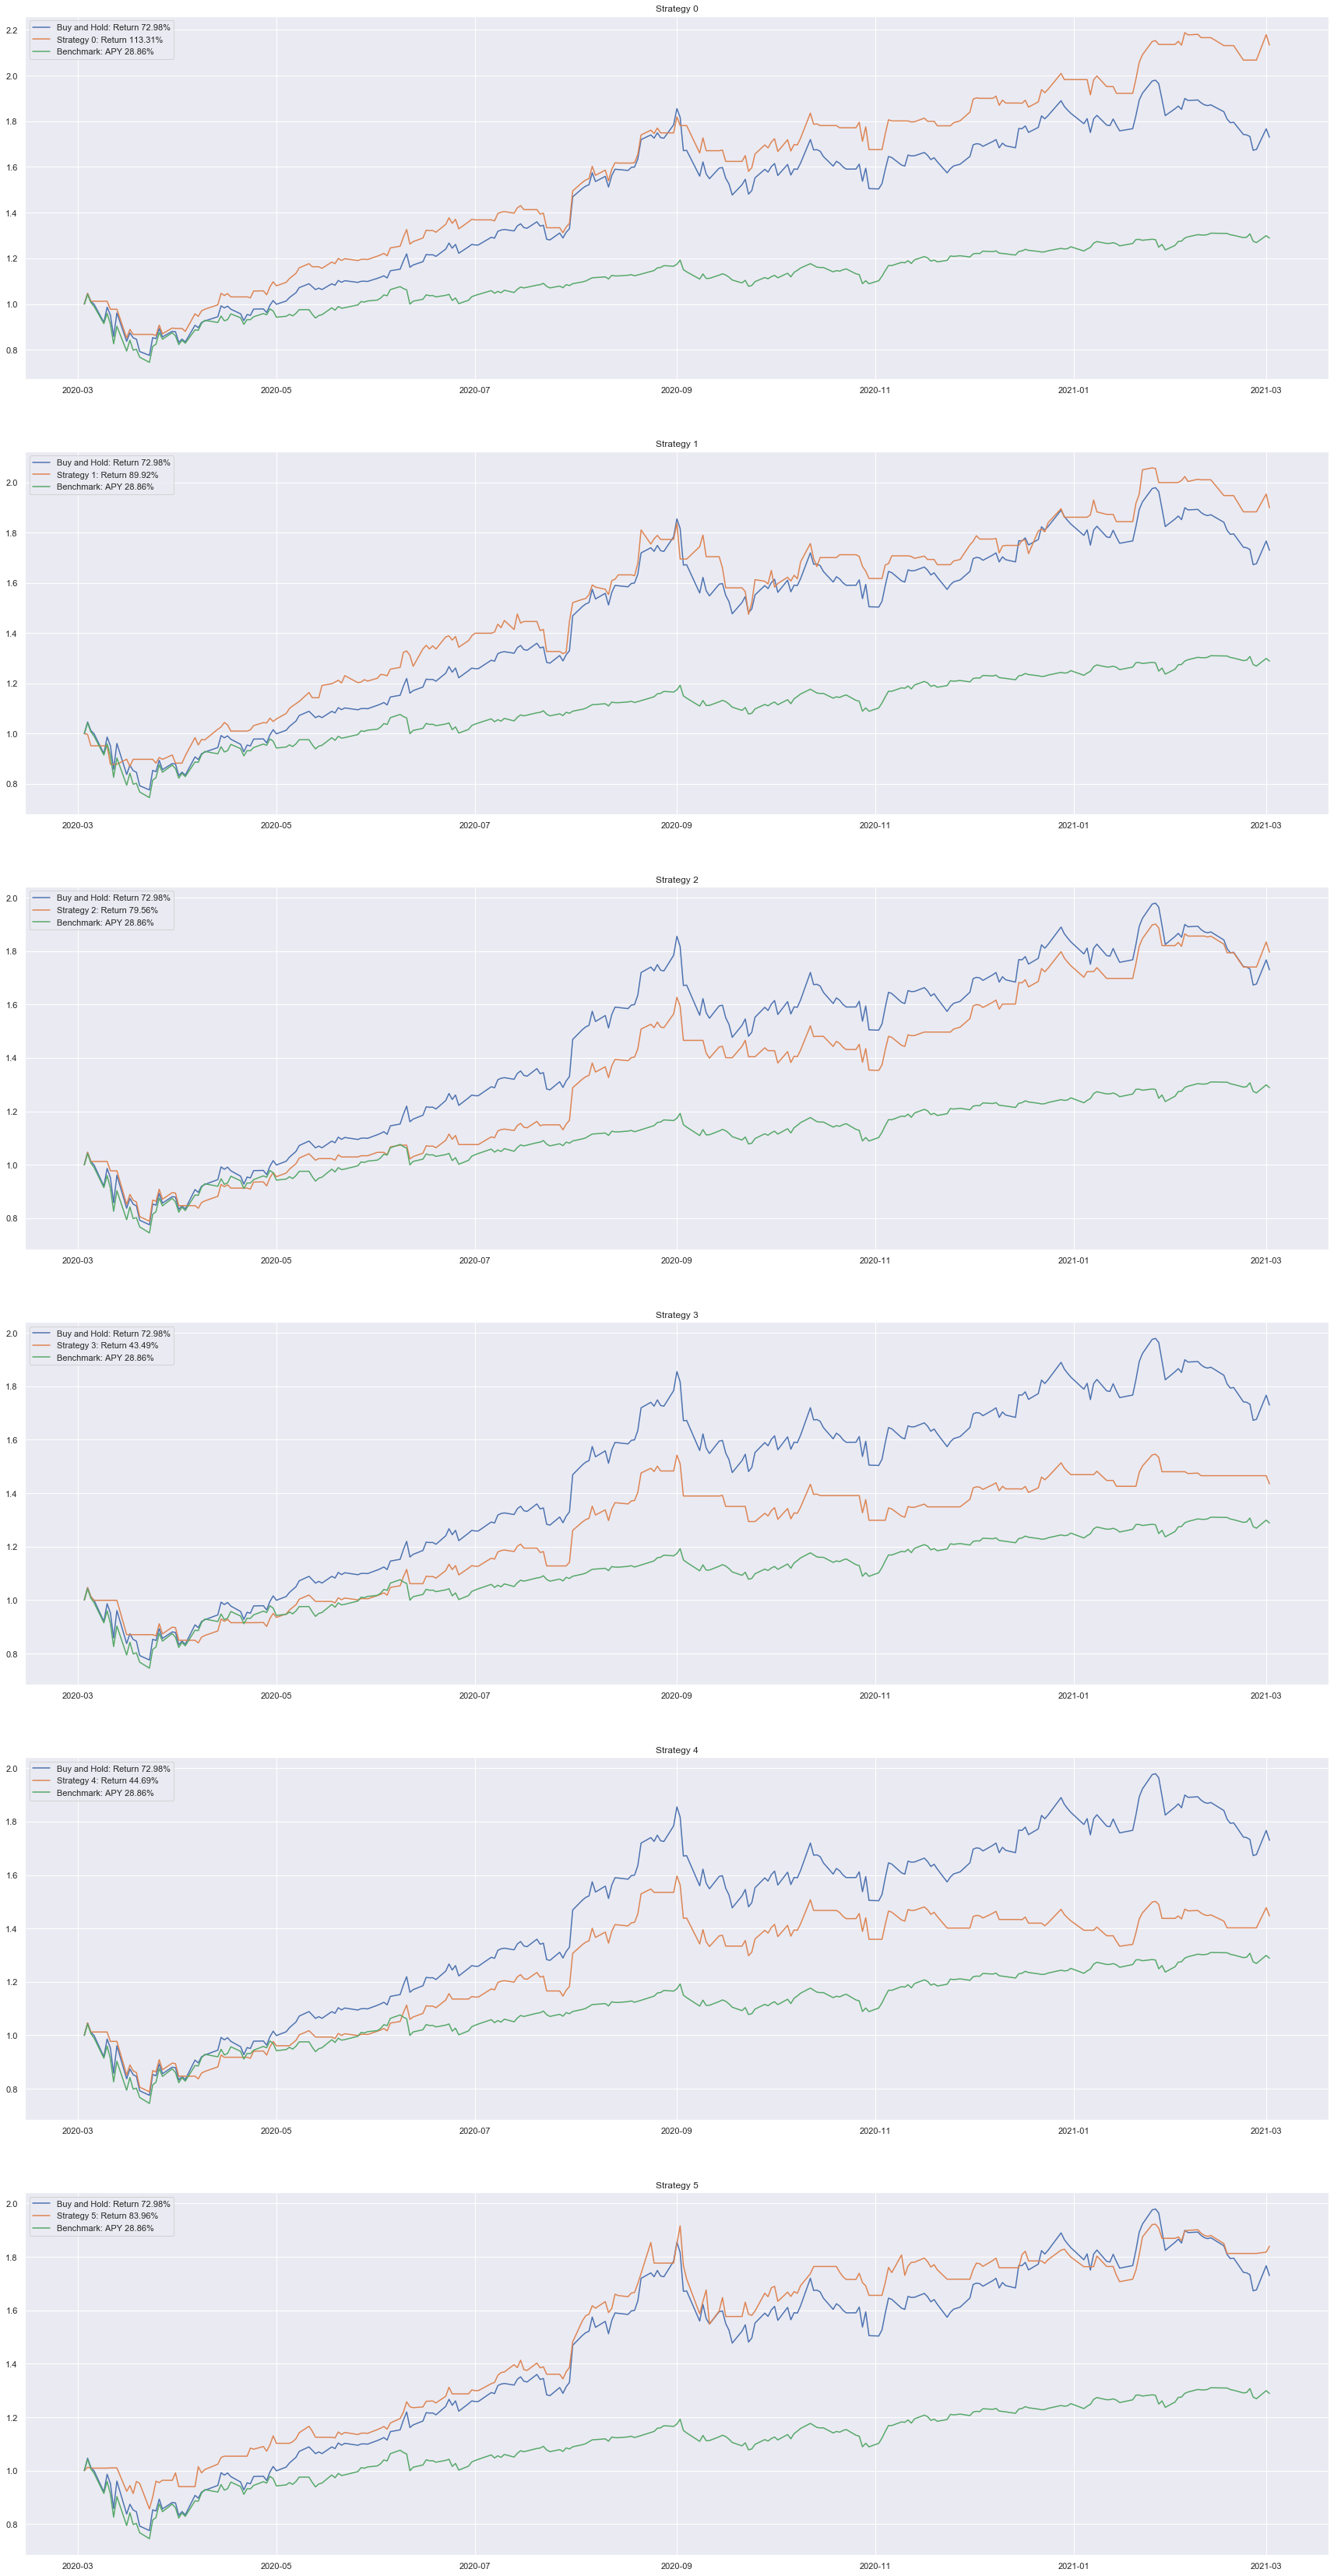

In [12]:
f, axes = plt.subplots(6, 1, figsize=(30, 60))
for i, vlist in enumerate(value_list):
    axes[i].plot(df.index.values[-253:-1], df['Close'].values[-253:-1]/df['Close'].values[-253])
    axes[i].plot(df.index.values[-253:-1], vlist[-252:]/vlist[-252])
    axes[i].plot(df.index.values[-253:-1], 
                 benchmark_df['Close'].values[-253:-1]/benchmark_df['Close'].values[-253])
    axes[i].legend([f"Buy and Hold: Return {round((df['Close'].values[-2]/df['Close'].values[-253]-1)*100, 2)}%",
                    f'Strategy {i}: Return {round((vlist[-1]/vlist[-252]-1)*100, 2)}%',
                    f"Benchmark: APY {round((benchmark_df['Close'].values[-2]/benchmark_df['Close'].values[-253]-1)*100, 2)}%"
                   ])
    axes[i].set_title(f'Strategy {i}')
    
f.savefig(f'./images/{stock}-return-1y.png')

In [13]:
for i, vlist in enumerate(value_list):
    
    apy = []
    mdd = 1e10
    p = 253
    sr = sharp_ratio(vlist)
    
    
    for _ in range(len(vlist) - p):
        apy.append((vlist[_+p]/vlist[_]) - 1)
    
    for _ in range(1, len(vlist)):
        for j in range(_+1, len(vlist)):
            mdd = min(mdd, vlist[j]/vlist[_] - 1)
        
    

    print(f"\nStrategy {i}",
          "\nSharp Ratio:", sr,
          "\nMDD:", mdd, 
          #"\nMaximum return:", np.max(apy),
          f"\nOne Year Range: [{np.min(apy)}, {np.max(apy)}]"
          "\nAverage return:", np.mean(apy), 
          "\nMedian return:", np.percentile(apy, 50))


Strategy 0 
Sharp Ratio: 2.1877036157581977 
MDD: -0.2524241805076599 
One Year Range: [0.19406354427337646, 1.5615448951721191]
Average return: 0.7027936158834294 
Median return: 0.6776998043060303

Strategy 1 
Sharp Ratio: 1.0808115067344486 
MDD: -0.3022587299346924 
One Year Range: [-0.15197408199310303, 1.2554068565368652]
Average return: 0.41905432230515716 
Median return: 0.4243839979171753

Strategy 2 
Sharp Ratio: 2.044165963437366 
MDD: -0.24613308906555176 
One Year Range: [0.0223388671875, 1.1721267700195312]
Average return: 0.4615177917561887 
Median return: 0.4352494478225708

Strategy 3 
Sharp Ratio: 1.0800066396152286 
MDD: -0.2781723141670227 
One Year Range: [-0.248879075050354, 0.9693769216537476]
Average return: 0.30267113779645516 
Median return: 0.34717321395874023

Strategy 4 
Sharp Ratio: 1.1145101005218019 
MDD: -0.33339935541152954 
One Year Range: [-0.11539256572723389, 0.7580643892288208]
Average return: 0.28203867156192125 
Median return: 0.268307566642761

In [14]:
vlist = benchmark_df['Close'].values[4:len(df)-1]/benchmark_df['Close'].values[4]
sr_sp500 = sharp_ratio(vlist)
for _ in range(len(vlist) - p):
        apy.append((vlist[_+p]/vlist[_]) - 1)
    
for _ in range(1, len(vlist)):
    for j in range(_+1, len(vlist)):
        mdd = min(mdd, vlist[j]/vlist[_] - 1)
print(f"Benchmark\nSharp ratio: {sr_sp500}",
      "\nMDD:", mdd, 
      #"\nMaximum return:", np.max(apy),
      f"\nOne Year Range: [{np.min(apy)}, {np.max(apy)}]"
      "\nAverage return:", np.mean(apy), 
      "\nMedian return:", np.percentile(apy, 50))

Benchmark
Sharp ratio: 0.9579505874398682 
MDD: -0.3392496000265327 
One Year Range: [-0.21628930316340889, 1.3669846057891846]
Average return: 0.23202215549999416 
Median return: 0.17530839050622415


In [15]:
vlist = df['Close'].values[4:len(df)-1]/df['Close'].values[4]
sr_bnh = sharp_ratio(vlist)
for _ in range(len(vlist) - p):
        apy.append((vlist[_+p]/vlist[_]) - 1)
    
for _ in range(1, len(vlist)):
    for j in range(_+1, len(vlist)):
        mdd = min(mdd, vlist[j]/vlist[_] - 1)
print(f"Buy and Hold\nSharp ratio: {sr_bnh}",
      "\nMDD:", mdd, 
      #"\nMaximum return:", np.max(apy),
      f"\nOne Year Range: [{np.min(apy)}, {np.max(apy)}]"
      "\nAverage return:", np.mean(apy), 
      "\nMedian return:", np.percentile(apy, 50))

Buy and Hold
Sharp ratio: 0.8412623888440035 
MDD: -0.38729694508624535 
One Year Range: [-0.2822754082259382, 1.5712367374671832]
Average return: 0.2655030260128806 
Median return: 0.20069439851452864
